# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***

---

---

This notebook contains the code for the P4 -> Advanced Lane Lines.

The document is organized as follows:

Firstly, the steps for the detection are executed for a single image.

    1. Camera calibration and distortion correction
    2. Color and gradient threshold
    3. Perspective transform
    4. Lane detection
    5. Measure of curvature ratius and offset
    6. Line representation on image

After that a pipeline is built, where all the steps are executed. Finally, the pipeline is used to detect the lines for the project and challenge videos.
   
    7. Pipeline definition
    8. Detection for project video
    9. Detection for challenge video

## 1. Camera calibration and distortion correction

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

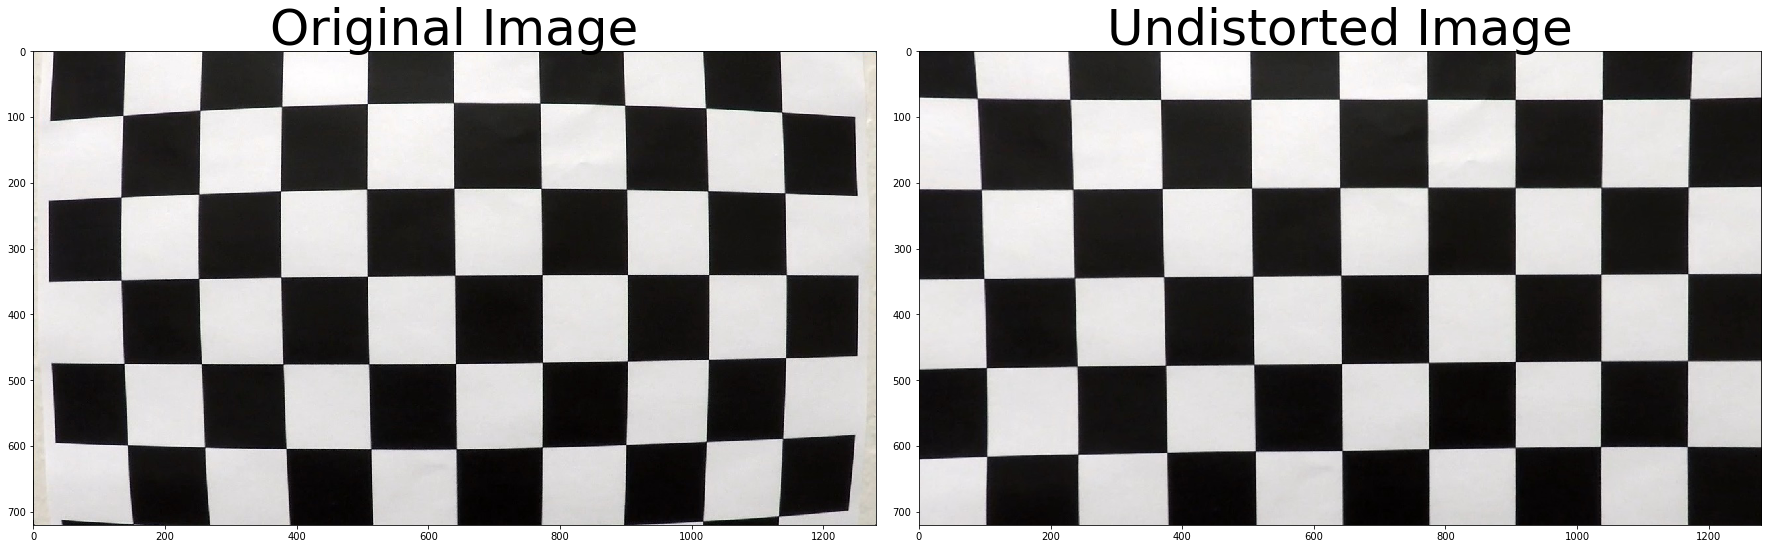

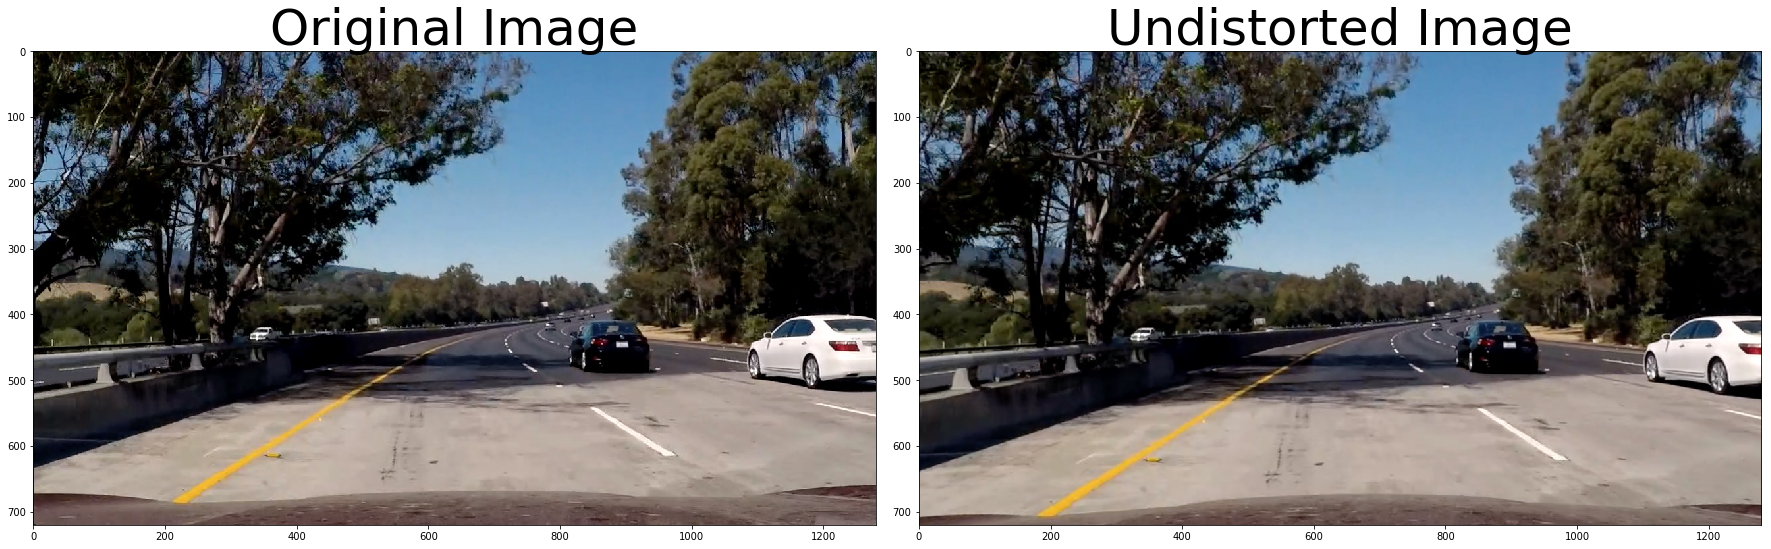

In [2]:
def calibration():

    # Read in an image
    images = glob.glob('camera_cal/calibration*.jpg')

    # prepare object points
    nx = 9
    ny = 6

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points (for example, (3,1,0))
    objp= np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in images:

        # Read in each image
        image = mpimg.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    # Read test image for calibration
    image_test_calibration = mpimg.imread('test_images/test_image_calibration.jpg')

    # Calibrate via OpenCV function calibrateCamera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
                                                       image_test_calibration.shape[1::-1], None, None)
    # Return distortion coefficient and camera matrix
    return mtx, dist, image_test_calibration

# Calibrate camera
mtx, dist, image_test_calibration = calibration()

# Undistort test image for calibration
undistorted = cv2.undistort(image_test_calibration, mtx, dist, None, mtx)

# Read test image
image = mpimg.imread('test_images/test5.jpg')

# Undistort test image
undistorted2 = cv2.undistort(image, mtx, dist, None, mtx)

# Display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_test_calibration)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Display results
f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f2.tight_layout()
ax3.imshow(image)
ax3.set_title('Original Image', fontsize=50)
ax4.imshow(undistorted2)
ax4.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 2. Color and gradient threshold

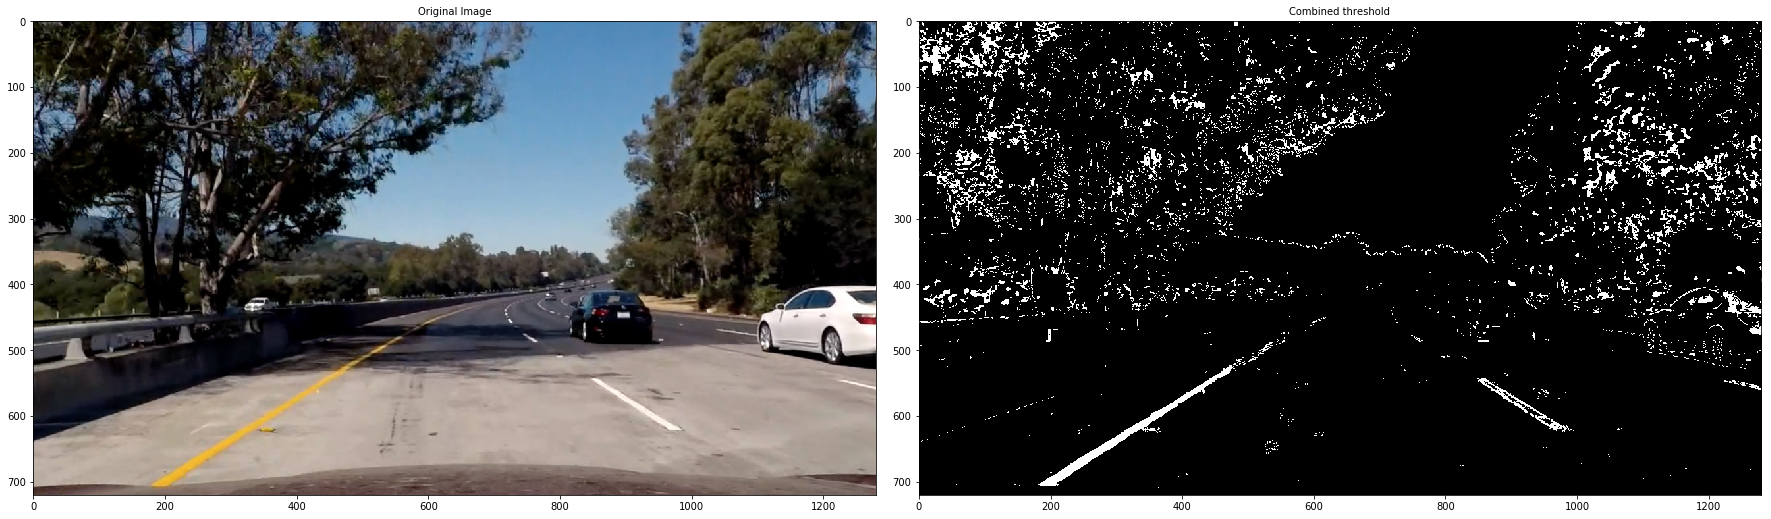

In [3]:
# Sobel function (only for x axis)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take absolute value
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as binary image
    return sxybinary

# Gradient direction function
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxybinary = np.zeros_like(dir_grad)
    sxybinary[(dir_grad > thresh[0]) & (dir_grad < thresh[1])] = 1
    # 6) Return this mask as binary image
    return sxybinary

# Function to apply threshold to V component of HSV color representation
def v_threshold(img, v_thresh=(15,100)):
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
	# Threshold channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    return v_binary

# Function to apply threshold to H component of HLS color representation
def h_threshold(img, h_thresh=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
	# Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    return h_binary
	
# Function to apply threshold to S component of HLS color representation
def s_threshold(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
	# Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Undistort image
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(12, 90))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.6, 1.5))
v_binary = v_threshold(undist, v_thresh=(145,255))
h_binary = h_threshold(undist, h_thresh=(15,105))
s_binary = s_threshold(undist, s_thresh=(145,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(dir_binary == 1) & (gradx == 1) & (v_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined threshold', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 3. Perspective transform


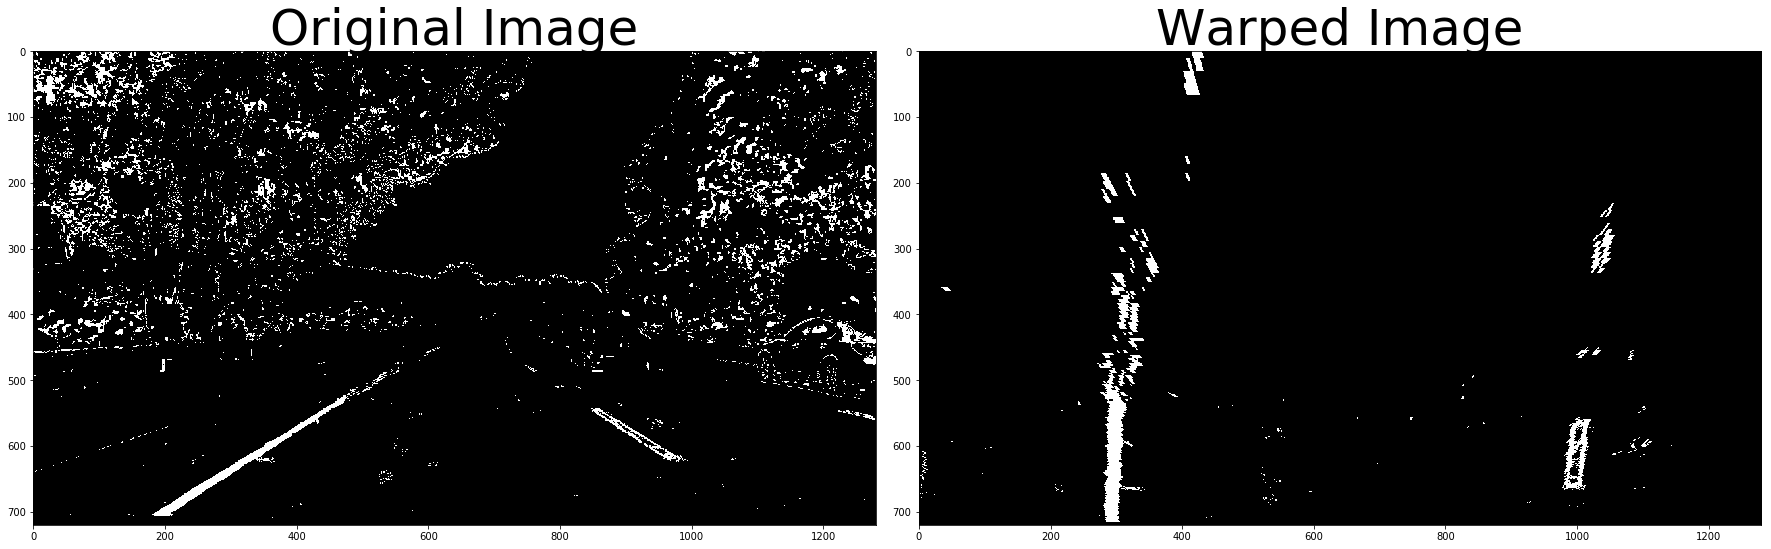

In [4]:
# Function to obtain warped image
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

# Define four original points and determine their position in warped image
src = np.float32([[206,720], [1097,720], [580,460], [700,460]])
dst = np.float32([[320,720], [960,720], [320,0], [960,0]])

# Call warper function with image and source and destination points as arguments
binary_warped, Minv = warper(combined, src, dst)

# Display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 4. Lane detection

This step is divided in:
- Application of sliding window and polynomial for detection of first frame
- Detection without applying sliding window for rest of frames


### 4.1. Sliding window and fit polynomial - First frame

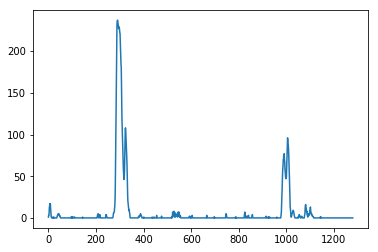

In [5]:
# Calculate histogram of warped image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

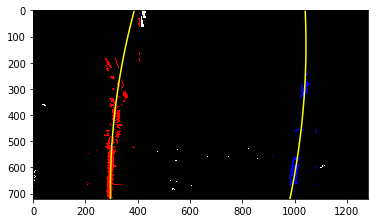

In [6]:
# Function to apply sliding window and fit polynomial for first frame
def slid_window_fit_poly(binary_warped, histogram):

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

# Call function
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
slid_window_fit_poly(binary_warped, histogram)

#Display results
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### 4.2. Skip sliding window - Rest of frames

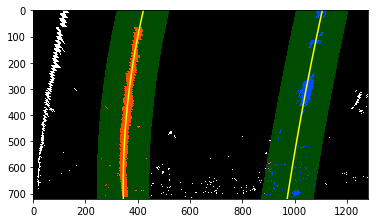

In [7]:
# Function to detect lines for rest of frames
def new_slid_window_fit_poly(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

# Apply steps for new image
image = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(12, 90))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.6, 1.5))
v_binary = v_threshold(undist, v_thresh=(145,255))
h_binary = h_threshold(undist, h_thresh=(15,105))
s_binary = s_threshold(undist, s_thresh=(145,255))

combined_gradient = np.zeros_like(dir_binary)
combined_gradient[(dir_binary == 1) & (gradx == 1) & (v_binary == 1)] = 1

combined_color = np.zeros_like(dir_binary)
combined_color[(h_binary == 1) & (s_binary == 1)] = 1

combined = np.zeros_like(combined_gradient)
combined[(combined_gradient == 1) | (combined_color == 1)] = 1

binary_warped, Minv = warper(combined, src, dst)

# Call function
result, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty = \
new_slid_window_fit_poly(binary_warped, left_fit, right_fit)

# Display results
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## 5. Measuring curvature and offset

In [8]:
# Function to calculate curvature and offset
def meas_curvature_offset(ploty, left_fit, right_fit, leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Build polynomials for left and right lines
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate offset in pixels evaluating polynomials in center of Y axis and calculating middle point between them in X axis
    dist = (right_fitx[359]+left_fitx[359]) / 2
    # Convert to meters
    dist_meters = np.absolute((dist-640)*xm_per_pix)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, dist_meters

#Call function
left_meas, right_meas, dist_meters = meas_curvature_offset(ploty, left_fit, right_fit, leftx, lefty, rightx, righty)

print("Radius of curvature (left): {} m".format(left_meas))
print("Radius of curvature (right): {} m".format(right_meas))
print("Offset: {} m".format(dist_meters))

Radius of curvature (left): 950.0382927349115 m
Radius of curvature (right): 3755.20749883796 m
Offset: 0.3013531292762499 m


## 6. Line representation

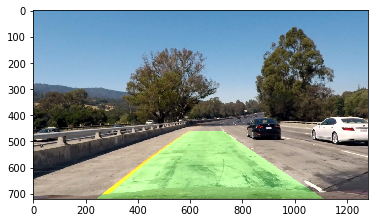

In [9]:
# Function to view lines
def view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

# Call function
result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, image, undist)

# Display results
plt.imshow(result)
plt.show()

## 7. Pipeline definition

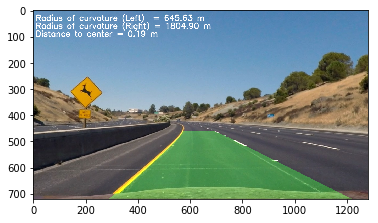

In [10]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Pipeline function
def pipeline(img):
        
    # Undistort
    undist = cv2.undistort(img, pipeline.mtx, pipeline.dist, None, pipeline.mtx)

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(12, 90))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.6, 1.5))
    v_binary = v_threshold(undist, v_thresh=(145,255))
    h_binary = h_threshold(undist, h_thresh=(15,105))
    s_binary = s_threshold(undist, s_thresh=(145,255))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[(gradx == 1) & (dir_binary == 1) & (v_binary == 1)] = 1

    combined_color = np.zeros_like(dir_binary)
    combined_color[(h_binary == 1) & (s_binary == 1)] = 1

    combined = np.zeros_like(combined_gradient)
    combined[(combined_gradient == 1) | (combined_color == 1)] = 1
    
    # Warp image
    binary_warped, Minv = warper(combined, src, dst)
    
    # Calculate histogram
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Detect lines and calculate polynomials
    if pipeline.first == True:
        out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = slid_window_fit_poly(binary_warped, histogram)
        
        pipeline.left_fit = left_fit
        pipeline.right_fit = right_fit
        pipeline.first = False
    else:
        result, ploty, pipeline.left_fit, pipeline.right_fit, left_fitx, right_fitx, leftx, lefty, rightx, \
        righty = new_slid_window_fit_poly(binary_warped, pipeline.left_fit, pipeline.right_fit)
    
    # Calculate radius of curvature and offset
    pipeline.left_curverad, pipeline.right_curverad, pipeline.dist_meters = meas_curvature_offset\
    (ploty, pipeline.left_fit, pipeline.right_fit, leftx, lefty, rightx, righty)
    
    # View lines
    result = view_lines(binary_warped, left_fitx, right_fitx, ploty, Minv, img, undist)
    
    # Display calculations in image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of curvature (Left)  = %.2f m' % (pipeline.left_curverad), (10, 40), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature (Right) = %.2f m' % (pipeline.right_curverad), (10, 70), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Distance to center = %.2f m' % (pipeline.dist_meters), (10, 100), font, 1,\
                (255, 255, 255), 2, cv2.LINE_AA)

    return result

# Read test image
img = mpimg.imread('test_images/test2.jpg')

# Call pipeline
pipeline.first = True
pipeline.mtx = mtx
pipeline.dist = dist
result = pipeline(img)
    
# Display results
plt.imshow(result)
plt.show()     

## 8. Detection for project video


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('project_video.mp4').subclip(15,50)
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:07<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 6min 8s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## 9. Detection for challenge video

In [13]:
challenge_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:17<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 2min 18s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))